<a href="https://colab.research.google.com/github/Fibonacci1664/Pix2Pix/blob/main/MyPix2Pix_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTS**

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.applications.vgg16 import VGG16
#from keras.preprocessing import image
import keras.utils as image
from keras.applications.vgg16 import preprocess_input
from keras.metrics import Mean

import numpy as np

print(tf.__version__)

2.12.0


# **LOAD SKETCH2POKEMON DATASET**

(256, 512, 3)


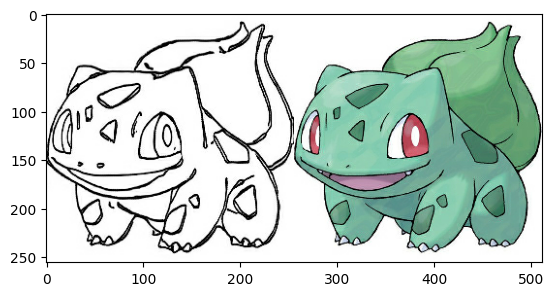

In [ ]:
input_file = '/content'

PATH = input_file

# Each original image is of size 256 x 512, which in and of itself contains two 256 x 256 images
# Print out a smaple image to ensure the dataset has loaded correctly
sample_image = tf.io.read_file(str(PATH+'/train/0.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

plt.figure()
plt.imshow(sample_image)

# **PREPROCESS DATA**

### **SPLIT IMAGES INTO TWO SEPARATE IMAGES, REAL/LABEL or TARGET/INPUT**

(256, 256, 3)


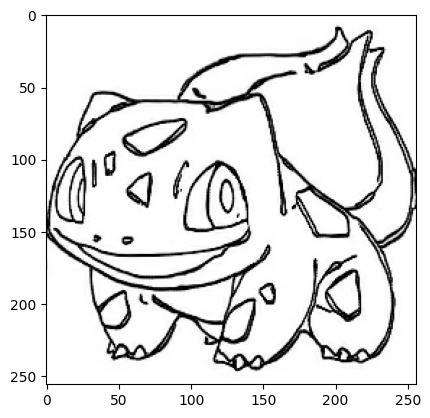

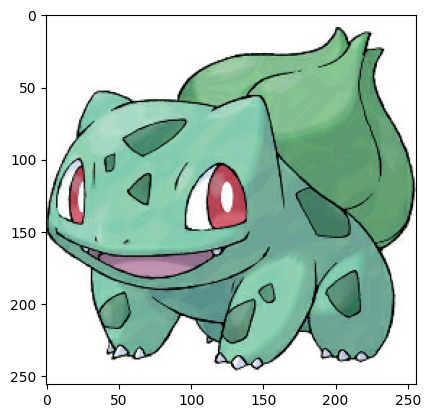

In [ ]:
# Define a function that loads image files and outputs two image tensors, these two images will be the 256 x 512 separated

# Image file is Python object
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)     # Tensor
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with the sketch image
    # - one with the real image
    w = tf.shape(image)[1]                # 512                 # Tensor
    w = w // 2                            # 256
    sketch_image = image[:, :w, :]        # From start - 256    # Tensor
    real_image = image[:, w:, :]          # From 256 - end      # Tensor

    # Convert both images to float32 tensors
    sketch_image = tf.cast(sketch_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return sketch_image, real_image

# Plot a sample of the input (sketch image) and real images
sketch, real = load(str(PATH+'/train/0.jpg'))                   # Tensor

print(sketch.shape)

# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(sketch / 255.0)
plt.figure()
plt.imshow(real / 255.0)

### **HELPER FUNCTIONS TO AUGMENT DATA**

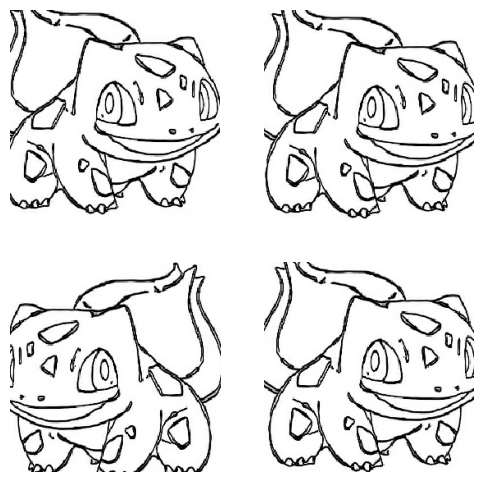

In [ ]:
# As described in the pix2pix paper, apply random jittering and mirroring to preprocess the training set.

# Define several functions that:

# Resize each 256 x 256 image to a larger height and width, 286 x 286.
# Randomly crop it back to 256 x 256.
# Randomly flip the image horizontally i.e. left to right (random mirroring).
# Normalize the images to the [-1, 1] range.

# The pokemon train set has 830 images
BUFFER_SIZE = 830
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # Tensor
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # Tensor

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1] # Tensors

# Normalizing the images to [-1, 1] using scaling normalization
def normalize_two(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image # Tensors

# Normalizing the image to [-1, 1] using scaling normalization
def normalize_one(input_image):
    input_image = (input_image / 127.5) - 1
    return input_image # Tensor

# Normalizing the images to [-1, 1] using channel-wise mean subtraction normalization
# This is important as this is what the vgg-16 network used to train on
# Something is not quite right with this as it's causing streaking type artefact across the generated images
def normalize_channel_wise_two(input_image, real_image):
    mean = tf.reduce_mean(input_image, axis=(1, 2), keepdims=True)
    std = tf.math.reduce_std(input_image, axis=(1, 2), keepdims=True)
    input_image = (input_image - mean) / std
    real_image = (real_image - mean) / std
    
    return input_image, real_image # Tensors

# Normalizing a single image to [-1, 1] using channel-wise mean subtraction normalization
# This is important as this is what the vgg-16 network used to train on
def normalize_channel_wise_one(input_image):
    mean = tf.reduce_mean(input_image, axis=(1, 2), keepdims=True)
    std = tf.math.reduce_std(input_image, axis=(1, 2), keepdims=True)
    input_image = (input_image - mean) / std 
    
    return input_image # Tensor

def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image) 

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image # Tensors

# Inspect some of the preprocessed output
plt.figure(figsize=(6, 6))

for i in range(4):
    rand_jit_sketch, rand_jit_real = random_jitter(sketch, real) # Tensors
    plt.subplot(2, 2, i + 1)
    plt.imshow(rand_jit_sketch / 255.0)
    plt.axis('off')

plt.show()

### **HELPER FUNCTIONS THAT LOAD AND PREPROCESS THE TRAIN/TEST SETS**

In [ ]:
# Helper functions that load and preprocess the training and test sets
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize_two(input_image, real_image)
    #input_image, real_image = normalize_channel_wise_two(input_image, real_image)

    return input_image, real_image # Tensors

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                    IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize_two(input_image, real_image)
    #input_image, real_image = normalize_channel_wise_two(input_image, real_image)

    return input_image, real_image # Tensors

# **BUILD INPUT PIPELINE**

In [ ]:
# Build an input pipeline with tf.data
train_dataset = tf.data.Dataset.list_files(str(PATH+'/train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)  # Although suffled here, the dataset is also shuffled again during training before each new epoch
train_dataset = train_dataset.batch(BATCH_SIZE) # Tensor

try:
    test_dataset = tf.data.Dataset.list_files(str(PATH+'/test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH+'/val/*.jpg'))

test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE) # Tensor

# **DUAL MASK INJECTION**

In [ ]:
def dual_mask_injection(feat, mask, in_channels):

    # Reshaping was required to take care of broadcasting issues when
    # trying to carry out element-wise multiplication and element-wise addition
    #weight_a = tf.Variable(tf.ones((1, in_channels, 1, 1))*1.1)
    weight_a = tf.Variable(tf.ones((1, 1, 1, in_channels))*1.1)
    #print("weight_a: ", weight_a)
    #weight_a = tf.reshape(weight_a, [1, 1, 1, in_channels])

    #weight_b = tf.Variable(tf.ones((1, in_channels, 1, 1))*0.9)
    weight_b = tf.Variable(tf.ones((1, 1, 1, in_channels))*0.9)
    #print("weight_b: ", weight_b)
    #weight_b = tf.reshape(weight_b, [1, 1, 1, in_channels])

    #bias_a = tf.Variable(tf.zeros((1, in_channels, 1, 1))+0.01)
    bias_a = tf.Variable(tf.zeros((1, 1, 1, in_channels))+0.01)
    #print("bias_a: ", bias_a)
    #bias_a = tf.reshape(bias_a, [1, 1, 1, in_channels])

    #bias_b = tf.Variable(tf.zeros((1, in_channels, 1, 1))+0.01)
    bias_b = tf.Variable(tf.zeros((1, 1, 1, in_channels))+0.01)
    #print("bias_b: ", bias_b)
    #bias_b = tf.reshape(bias_b, [1, 1, 1, in_channels])

    feat_a = weight_a * feat * mask + bias_a

    #print("feat_a: ", feat_a)

    feat_b = weight_b * feat * (1-mask) + bias_b

    #print("feat_b: ", feat_b)

    final_tensor = feat_a + feat_b
    #print("Final DMI tensor before return: ", final_tensor)

    return final_tensor # Tensor


# **FEATURE MAP TRANSFORMATION**

In [ ]:
# step 1:
# Get the Contour features (C) and Plain-area feature (P)
# Use the style-image's sketch as a mask (M), so we can filter the values in the style-image's feature maps (F)
# With (M*F): (element-wise), we can get a feature-map (FM_C), that only have the feature values of the contours, 
# and with (1-M)*F: (element-wise), we can get the (FM_P) with features only around the plain areas of the image.
# Then we use a max-pooling layer to extract the filtered feature values, because the filtered feature-map will be sparse
# Finally, we will have two 4x4 feature-maps, one for the edge and one for the rest.

# step 2:
# Then we impose the features into the content feature map. To begin with, we fill a blank feature-map with same size 
# of the content feature-map with the Edge feature-map, then we use the content-sketch as mask to filter this feature map.
# Do the same thing with Plain feature-map. Then we can add the 2 feature-map into one.

def rescale(tensor, range=(0, 1)):
    return (tensor - tf.reduce_min(tensor)) / (tf.reduce_max(tensor) - tf.reduce_min(tensor)) * (range[1]-range[0]) + range[0]

def FeatMapTransfer(style_feat, style_skt, content_skt, hw=8):

    style_feat = tf.nn.avg_pool2d(style_feat, hw, 1, "VALID")
    #print("style_feat shape in FMT: ", style_feat.shape)
    
    # Is this just normalizing?? These images have already been normalised
    #style_skt = rescale(tf.nn.avg_pool2d(style_skt, hw, 1, "VALID"))
    #content_skt = rescale(tf.nn.avg_pool2d(content_skt, hw, 1, "VALID"))

    ######### STEP 1 #########
    #style_skt = tf.nn.avg_pool2d(style_skt, hw, 1, "VALID")
    #print("style_skt shape in FMT: ", style_skt.shape)
    content_skt = tf.nn.avg_pool2d(content_skt, hw, 1, "VALID")
    #print("content_skt shape in FMT: ", content_skt.shape)

    content_feat = style_feat * style_skt
    #print("content_feat shape in FMT: ", content_feat.shape)
    plain_feat = style_feat * (1-style_skt)
    #print("plain_feat shape in FMT: ", plain_feat.shape)

    ######### STEP 2 CONTENT AREA #########
    content_feat = tf.nn.max_pool2d(content_feat, [5, 5], [2, 2], "SAME")
    #print("content_feat shape in FMT, first pool: ", content_feat.shape)
    content_feat = tf.nn.max_pool2d(content_feat, [5, 5], [2, 2], "SAME")
    #print("content_feat shape in FMT, second pool: ", content_feat.shape)
    content_feat = tf.nn.avg_pool2d(content_feat, [hw//8, hw//8], [1, 1], "VALID")
    #print("content_feat shape in FMT, avg pool 2d: ", content_feat.shape)

    ######### STEP 3 CONTENT AREA #########
    content_feat = tf.tile(content_feat, [1, 4, 4, 1])
    #print("content_feat shape in FMT, tile: ", content_feat.shape)

    ######### STEP 2 PLAIN AREA #########
    plain_feat = tf.nn.max_pool2d(plain_feat, [5, 5], [2, 2], "SAME")
    #print("plain_feat shape in FMT, first pool: ", plain_feat.shape)
    plain_feat = tf.nn.max_pool2d(plain_feat, [5, 5], [2, 2], "SAME")
    #print("plain_feat shape in FMT, second pool: ", plain_feat.shape)
    plain_feat = tf.nn.avg_pool2d(plain_feat, [hw//8, hw//8], [1, 1], "VALID")
    #print("plain_feat shape in FMT, avg pool 2d: ", plain_feat.shape)

    ######### STEP 3 PLAIN AREA #########
    plain_feat = tf.tile(plain_feat, [1, 4, 4, 1])
    #print("plain_feat shape in FMT, tile: ", plain_feat.shape)

    ######### STEPS 4 & 5 #########
    final_tensor = (content_feat*content_skt) + (plain_feat*(1-content_skt))
    #print("final_tensor shape before return from FMT: ", final_tensor.shape)

    final_tensor_tile = tf.tile(plain_feat, [1, 1, 1, 6])
    #print("final_tensor_tile shape before return from FMT: ", final_tensor_tile.shape)

    return final_tensor_tile # Tensor

    #return edge_feat*content_skt + plain_feat*(1-content_skt)

# **VGG-16 MODEL**

In [ ]:
# create an instance of the VGG-16 model
#vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
vgg_model = VGG16(weights='imagenet', include_top=False)

#vgg_model.summary()

# **AdaIn**

In [ ]:
#https://github.com/jonrei/tf-AdaIN/blob/master/AdaIN.py

def AdaIN(content_features, style_features, alpha):
    '''
    Normalizes the `content_features` with scaling and offset from `style_features`.
    See "5. Adaptive Instance Normalization" in https://arxiv.org/abs/1703.06868 for details.
    '''
    style_mean, style_variance = tf.nn.moments(style_features, [1,2], keepdims=True)
    content_mean, content_variance = tf.nn.moments(content_features, [1,2], keepdims=True)
    epsilon = 1e-5
    normalized_content_features = tf.nn.batch_normalization(content_features, content_mean,
                                                            content_variance, style_mean, 
                                                            tf.sqrt(style_variance), epsilon)
    
    normalized_content_features = alpha * normalized_content_features + (1 - alpha) * content_features

    ###print("Normalized content features from AdaIn func: ", normalized_content_features)

    return normalized_content_features # Tensor


# **U-NET GENERATOR MODEL**

### **HELPER FUNCTION TO DEFINE AN ENCODER BLOCK** 

In [ ]:
# define an encoder block, we could add drop out during the downsampling as well, what effect does that have??
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization / or he_normal?
	#init = RandomNormal(stddev=0.02)
	init = tf.random_normal_initializer(0., 0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g # Tensor

### **HELPER FUNCTION TO DEFINE AN DECODER BLOCK**

In [ ]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	#init = RandomNormal(stddev=0.02)
	init = tf.random_normal_initializer(0., 0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g # Tensor

### **LOAD STYLE IMAGES** 

In [ ]:
OUTPUT_CHANNELS = 3

# Load the style image
img_path = 'starry_night_256.jpg'
style_image = image.load_img(img_path, target_size=(256, 256))
style_image = image.img_to_array(style_image)

#style_image = tf.io.read_file('starry_night_256.jpg')
#style_image = tf.image.decode_jpeg(style_image, channels=3)

# Normalize the style image
style_image = tf.cast(style_image, tf.float32)
style_image = normalize_one(style_image)

# expand the first dim so that the style image tensor is rank 4 for vgg
style_image = tf.expand_dims(style_image, axis=0)
style_image = preprocess_input(style_image) # Tensor
###print("style_image norm shape: ", style_image_norm.shape)

# Load the style image sketch
img_path = 'starry_night_256_sketch.jpg'
style_image_sketch = image.load_img(img_path, target_size=(256, 256))
style_image_sketch = image.img_to_array(style_image_sketch)

# Normalize the style image sketch
style_image_sketch = tf.cast(style_image_sketch, tf.float32)
style_image_sketch = normalize_one(style_image_sketch)

# expand the first dim so that the style image tensor is rank 4 for vgg
style_image_sketch = tf.expand_dims(style_image_sketch, axis=0)
style_image_sketch = preprocess_input(style_image_sketch)   # Tensor
###print("style_image_sketch norm shape: ", style_image_sketch_norm.shape)

### **GENERATOR MODEL - U-NET**

The generator model for Pix2Pix is implemented as a U-Net.

[Insert own diagram of U-Net with dims included]

Encoder: C64-C128-C256-C512-C512-C512-C512-C512

Decoder: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

In [ ]:
# Get the style feature map we'll need for FMT and AdaIn, and the loss functions
# Declared in a global scope and updated in the following function
# Global scope due to being used also in the train_step function
style_feature_map = vgg_model(style_image) # Tensor

In [ ]:
# Declared outside function scope as this is used in the train_step function
#style_feature_map
# u-net encoder-decoder generator model

# define the standalone generator model
# image_shape=(256,256,3) // That was parameters inside the function parenthesis
def define_generator(image_shape=(256,256,3)):

	#inputs = tf.keras.layers.Input(shape=[256, 256, 3])
	# weight initialization
	#init = RandomNormal(stddev=0.02)
	init = tf.random_normal_initializer(0., 0.02)
	# image input
	in_image = Input(shape=image_shape)
	#print("in_image shape: ", in_image.shape)
	#print("in_image values: ", in_image)

	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512) # Tensors
 
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b) # Tensor
 
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512) # Tensor
	###print("d1 shape: ", d1.shape) 

	############################################################## IMPLEMENTING DMI ##############################################################
	
	binary_mask = tf.where(in_image != 0, 1.0, 0.0)
	#print(binary_mask.shape)

	###print("in_image shape: ", in_image.shape)
	###print("in_image values: ", in_image)
	###print("binary_mask: ", binary_mask.shape)

	# feat = sketch input
	# mask = binary mask of the sketch input
	# in_channels = number of channels in the sketch input
	DMI_tensor = dual_mask_injection(in_image, binary_mask, 3) # Tensor

	# Ensure DMI tensor is of same datatype as what we want to concatenate with
	DMI_tensor = tf.cast(DMI_tensor, tf.float32) # Tensor
	###print("DMI_tensor shape: ", DMI_tensor.shape)

	############################################################## IMPLEMENTING DMI END ##########################################################

	############################################################## IMPLEMENTING ADAIN ############################################################

	# Get the content feature map from the input sketch using the vgg-16 model
	#content_feature_map = vgg.predict(in_image)				# Cannot use the predict method as this expects a tensorflow tensor or numpy array NOT a KerasTensor
	#content_feature_map = vgg_model(in_image) # Tensor
	###print("content feature map shape: ", content_feature_map.shape)
	
	# Where the old load of the style image was, just incase it needs to go back here!
 
	# Update the style feature map as necessary, get the style feature map we'll need for FMT and AdaIn, and the loss functions
	style_feature_map = vgg_model(style_image) # Tensor
	#style_feature_map = vgg_model.predict(style_image_norm)
	###print("style feature map shape: ", style_feature_map.shape)

	# plt.figure()
	# plt.imshow(style_image)

	# Pass both the content feature map and style feature map to AdaIn function
	adaIn_feature_map = AdaIN(content_feature_map, style_feature_map, 0.5) # shape(1, 8, 8, 512) - 32,768 # Tensor
	###print("adain feature map shape: ", adaIn_feature_map.shape)

	############################################################## IMPLEMENTING ADAIN END ########################################################

	############################################################## IMPLEMENTING FEATURE MAP TRANSFORMATION #######################################

	#base_model = VGG19(weights='imagenet')
	FMT_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block4_pool').output)
 
	# Where the old load of the style image sketch was, just incase it needs to go back here!
 
	# Get the style sketch feature map
	style_sketch_feature_map = vgg_model(style_image_sketch)
	###print("style sketch feature map shape: ", style_sketch_feature_map.shape)

	# might need to upsample the style_feature map before passing, authors use 16x16 - 64x64
	#style_feature_map_up_sampled = tf.keras.layers.UpSampling2D(size=(2,2))(style_feature_map)
	#print("style_feature_map_up_sampled shape: ", style_feature_map_up_sampled.shape)
	#fmt_output = FeatMapTransfer(style_feature_map, style_image_sketch_norm, in_image)
	fmt_output = FeatMapTransfer(style_feature_map, style_sketch_feature_map, content_feature_map)
	###print("fmt_output shape: ", fmt_output.shape)

	fmt_output_reshape = tf.reshape(fmt_output, (1, 256, 256, 3))
	###print("fmt_output_reshape shape: ", fmt_output_reshape.shape)

	FMT_block4_pool_features = FMT_model(fmt_output_reshape)
	###print("FMT_block_pool_features: ", FMT_block4_pool_features.shape)	# shape(1, 16, 16, 512), concat with d4!

	############################################################## IMPLEMENTING FEATURE MAP TRANSFORMATION END ###################################

	d2 = decoder_block(d1, e6, 512)
	###print("d2 shape: ", d2.shape)
 
	# Upsample to allow concat of adain feature map tensor with decoder layer
	upsampled_d2 = tf.keras.layers.UpSampling2D(size=(2,2))(d2)
	###print("upsampled_d2 shape: ", upsampled_d2.shape)
 
	# Concat adain feature map and upsampled d2
	concatAdain_upd2 = tf.concat([adaIn_feature_map, upsampled_d2], axis=-1)
	###print("Concat adain feature map and up d2 shape: ", concatAdain_upd2.shape)
 
	# Upsample to allow concat of DMI tensor with decoder layer
	upsampled_d2_new = tf.keras.layers.UpSampling2D(size=(32,32))(concatAdain_upd2)
	concatDMI_upd2 = tf.concat([DMI_tensor, upsampled_d2_new], axis=-1)
	###print("Concat DMI tensor and up d2 shape: ", concatDMI_upd2.shape)
 
	# Downsample to allow passing on to d3
	downsample = tf.keras.layers.AveragePooling2D(pool_size=(64,64), strides=(64,64))(upsampled_d2_new)
	###print("downsample tensor shape: ", downsample.shape)

	d3 = decoder_block(downsample, e5, 512)
	###print("d3 tensor shape: ", d3.shape)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	###print("d4 shape: ", d4.shape)

	# Concat FMT_block_pool_features with d4
	concat_FMT_d4 = tf.concat([FMT_block4_pool_features, d4], axis=-1)
	###print("concat_FMT_d4 shape: ",  concat_FMT_d4.shape)

	d5 = decoder_block(concat_FMT_d4, e3, 256, dropout=False)
	###print("d5 shape: ", d5.shape)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	###print("d6 shape: ", d6.shape)

	d7 = decoder_block(d6, e1, 64, dropout=False)
	###print("d7 shape: ", d7.shape)
	# output
	g = Conv2DTranspose(OUTPUT_CHANNELS, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define image shape
image_shape = (256,256,3)
# create the model
gen_model = define_generator()
# summarize the model
#gen_model.summary()
# plot the model
#plot_model(gen_model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True, dpi=64)

# **TEST THE GENERATOR**

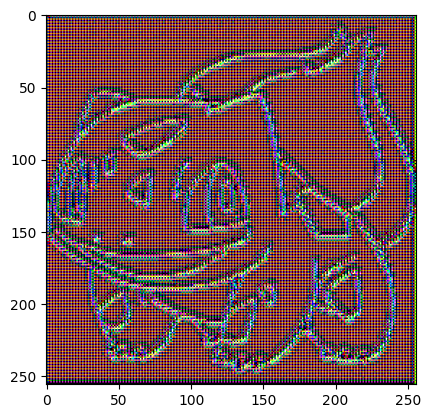

In [ ]:
# By the time we get here we MUST have shape(1, 256, 256, 3), even after all the DMI and AdaIn from the VGG

# TEST THE GENERATOR
gen_model_output = gen_model(sketch[tf.newaxis, ...], training=False)
#gen_model_output = tf.squeeze(gen_model_output, axis=0)
#print(gen_model_output)

plt.imshow(gen_model_output[0, ...])

# **DEFINE GENERATOR LOSS**

### **ORIGINAL GENERATOR LOSS FUNCTION**

In [ ]:
# GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

# The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
# The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
# This allows the generated image to become structurally similar to the target image.
# The formula to calculate the total generator loss is gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

LAMBDA = 100

binCrossEnt = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):

    gan_loss = binCrossEnt(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


### **UPDATED GENERATOR LOSS FUNCTION**

In [ ]:
# style = style image

# L(G) = E[log(P(G(Isketch, Istyle)))] + MSE(C(G(Isketch, Istyle)), Isketch) + MSE(S(G(Isketch, Istyle)), E(Istyle)).

LAMBDA = 100

binCrossEnt = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def updated_generator_loss(disc_generated_output, gen_output, target, idn_content, original_sketch, idn_style, style_feature_map):

    # E[log(P(G(Isketch, Istyle)))]
    gan_loss = binCrossEnt(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error, for enforcing perceptual loss, measuring the pixel-wise diff
    # between the Gen output and ground truth.
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    #print("Just before content loss")
    # MSE(C(G(Isketch, Istyle)), Isketch)
    content_loss = tf.keras.losses.MeanSquaredError()(idn_content, original_sketch)
    
    #print("Just before style loss")
    #print("idn_style shape: ", idn_style.shape)
    #print("style_feature_map shape: ", style_feature_map.shape)
    # MSE(S(G(Isketch, Istyle)), E(Istyle))
    style_loss = tf.keras.losses.MeanSquaredError()(idn_style, style_feature_map)
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + content_loss + style_loss

    return total_gen_loss, gan_loss, l1_loss, content_loss, style_loss


The training procedure for the generator is as follows:

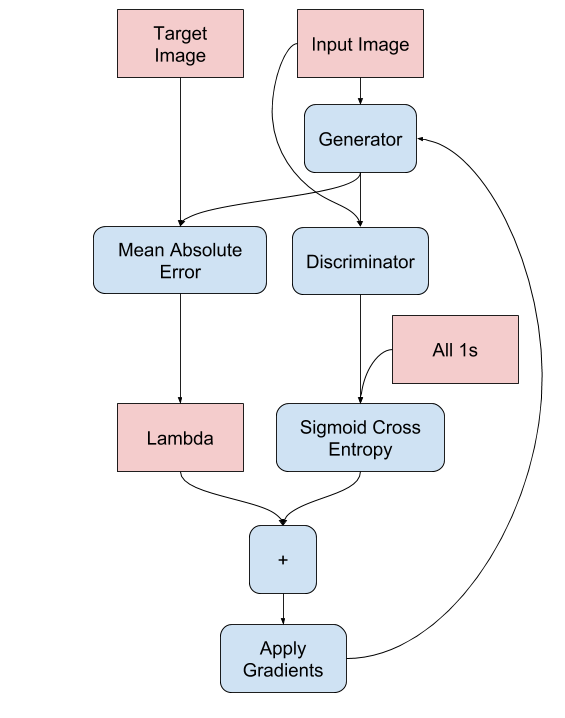

# **INSTANCE DE-NORMALIZATION**

In [ ]:
def idn(input_tensor, in_channel, style_dim, content_channel=1):

    #print("style dim: ", style_dim)
    # take a tensor as input, predict out the:
    # 1. grey-scale sketch image
    # 2. style feature vector

    # in adaIN: result_feature = [(content_feature - mu_c) / sigma_c ] * sigma_s + mu_s
    # so we can first get mu_s by a conv layer
    # then we can calculate the sigma_s from (result_feature - mu_s)
    # then we get the content feature using the (result_feature - mu_s)/sigma_s

    # Define the style_mu_conv layer
    style_mu_conv = tf.keras.Sequential([
        tf.keras.layers.Conv2D(in_channel, kernel_size=4, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(in_channel, kernel_size=4, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.GlobalAveragePooling2D()])
        #tf.keras.layers.AdaptiveAvgPool2D((1,1))])

    # Define the to_style layer
    to_style = tf.keras.layers.Dense(style_dim)

    # Define the to_content layer
    to_content = tf.keras.Sequential([
        tf.keras.layers.Conv2D(in_channel, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(content_channel, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.GlobalAveragePooling2D()])
        #tf.keras.layers.AdaptiveAvgPool2D((16,16))])

    # Compute style_mu
    style_mu = style_mu_conv(input_tensor)
    
    # Compute style_sigma
    feat_no_style_mu = input_tensor - style_mu
    style_sigma = tf.math.reduce_std(tf.reshape(feat_no_style_mu, (tf.shape(input_tensor)[0], in_channel, -1)), axis=-1)
    
    # Compute feat_content
    feat_content = feat_no_style_mu / tf.reshape(style_sigma, (tf.shape(input_tensor)[0], in_channel, 1, 1))

    # Transpose feat_content
    #feat_content = tf.transpose(feat_content, perm=[0, 2, 3, 1])
    
    # Compute style
    style = to_style(tf.concat([tf.reshape(style_mu, (tf.shape(input_tensor)[0],-1)), tf.reshape(style_sigma, (tf.shape(input_tensor)[0],-1))], axis=1))

    # Compute content
    content = to_content(feat_content)

    return content, style


# **PATCH GAN DISCRIMINATOR MODEL**

In [ ]:
# example of defining a 70x70 patchgan discriminator model
# functional API

# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
	#init = RandomNormal(stddev=0.02)
	init = tf.random_normal_initializer(0., 0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	zero_pad1 = tf.keras.layers.ZeroPadding2D()(d)

	# C512
	d = Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init, use_bias=False)(zero_pad1)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	zero_pad2 = tf.keras.layers.ZeroPadding2D()(d)
  
	# second last output layer
	# d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	# d = BatchNormalization()(d)
	# d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), strides=1, padding='same', kernel_initializer=init)(zero_pad2)

	#patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], d)
	# compile model
	# opt = Adam(learning_rate=0.0002, beta_1=0.5)
	# model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define image shape
image_shape = (256,256,3)
# create the model
disc_model = define_discriminator(image_shape)
# summarize the model
#disc_model.summary()
# plot the model
#plot_model(disc_model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True, dpi=64)


# **TEST THE DISCRIMINATOR**

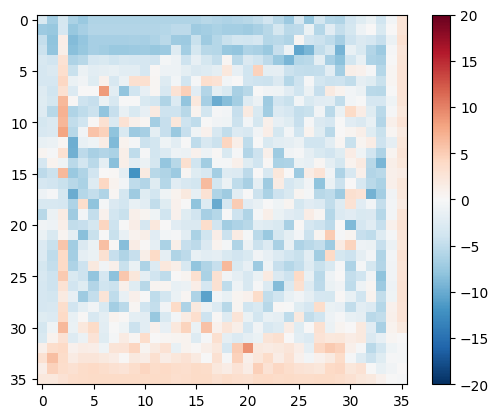

In [ ]:
# TEST THE DISCRIMINATOR
disc_output = disc_model([sketch[tf.newaxis, ...], gen_model_output], training=False)
plt.imshow(disc_output[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# **DEFINE DISCRIMINATOR LOSS**

### **ORIGINAL DISCRIMINATOR LOSS FUNCTION**

In [ ]:
# The discriminator_loss function takes 2 inputs: real images and generated images.
# real_loss is a sigmoid cross-entropy loss of the real images and an array of ones(since these are the real images).
# generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
# The total_loss is the sum of real_loss and generated_loss.

def discriminator_loss(disc_real_output, disc_generated_output):

    real_loss = binCrossEnt(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = binCrossEnt(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


### **UPDATED DISCRIMINATOR LOSS FUNCTION**

In [ ]:
# target = real / ground truth image

# L(D) = E[log(P(Ireal))] + E[log(1 − P(G(Isketch, Istyle)))] + MSE(S(Ireal), E(Ireal)) + MSE(C(Ireal), Ireal−sketch)

binCrossEnt = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def updated_discriminator_loss(disc_real_output, disc_generated_output, ground_truth_feature_map, original_sketch, style_feature_map, idn_style):
    
    # E[log(P(Ireal))]
    real_loss = binCrossEnt(tf.ones_like(disc_real_output), disc_real_output)

    # E[log(1 − P(G(Isketch, Istyle)))]
    generated_loss = binCrossEnt(tf.zeros_like(disc_generated_output), disc_generated_output)

    #print("Just before style loss")
    # MSE(S(Ireal), E(Ireal)) - Compare style extracted from original ground truth style image, and the style vector from the IDN
    style_loss = tf.keras.losses.MeanSquaredError()(style_feature_map, idn_style)

    #print("Just before content loss")
    #print("ground_truth_feature_map shape: ", ground_truth_feature_map.shape)
    #print("original_sketch shape: ", original_sketch.shape)

    # resize the original sketch image to match the size of the ground truth feature map
    # This is required for broadcasting
    resized_original_sketch = tf.image.resize(original_sketch, (8, 8))
    resized_original_sketch = tf.transpose(resized_original_sketch, perm=[3, 1, 2, 0]) # permute to match dimensions of resized orig sketch
    resized_original_sketch = tf.repeat(resized_original_sketch, repeats=512, axis=-1)
    #print("resized_original_sketch shape: ", resized_original_sketch.shape)
    #resized_original_sketch = tf.reshape(resized_original_sketch, shape=(1, 8, 8, 512))
    #print("resized_original_sketch shape: ", resized_original_sketch.shape)
    #resized_original_sketch = tf.transpose(resized_original_sketch, perm=[0, 3, 1, 2])# permute to match dimensions of ground truth feature map tensor
    #ground_truth_feature_map = tf.transpose(ground_truth_feature_map, perm=[3, 1, 2, 0])# permute to match dimensions of resized orig sketch
    #print("resized_original_sketch shape after perm: ", resized_original_sketch.shape)
    #print("ground_truth_feature_map shape after perm: ", ground_truth_feature_map.shape)

    # MSE(C(Ireal), Ireal−sketch) # this is not a subtraction, this is a MSE of the content (C) feature maps of both
    # the ground truth image (Ireal) and the input sketch image, which is a sketch of the ground truth i.e. (Ireal−sketch)  
    content_loss = tf.keras.losses.MeanSquaredError()(ground_truth_feature_map, resized_original_sketch)

    #resized_original_sketch = tf.transpose(resized_original_sketch, perm=[0, 2, 3, 1])  # permute back to original order
    # We don't need to bother permutating back as they as not used again in the function from this point
    #print("resized_original_sketch shape back to original perm order: ", resized_original_sketch.shape)

    # total discriminator loss
    total_disc_loss = real_loss + generated_loss + style_loss + content_loss

    return total_disc_loss, real_loss, generated_loss, style_loss, content_loss


The training procedure for the discriminator is shown below:

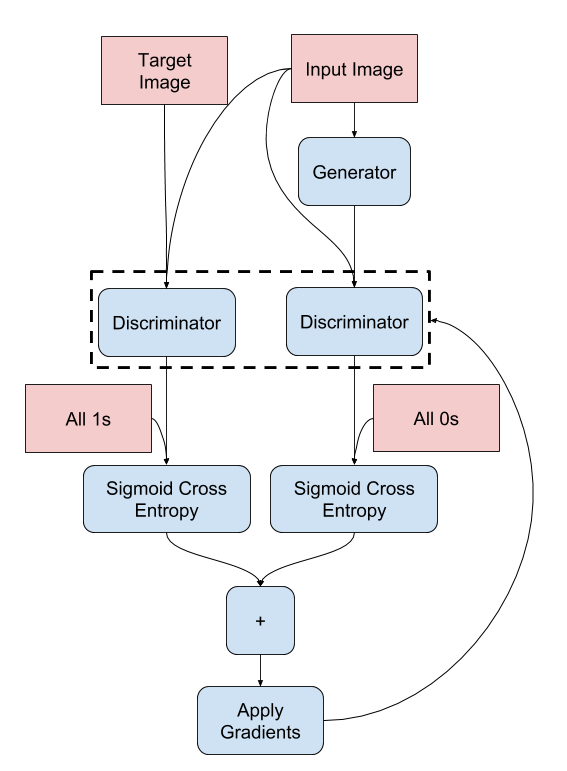

# **DEFINE OPTIMIZERS AND CHECKPOINT SAVER**

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=gen_model,
                                 discriminator=disc_model)

# **GENERATE IMAGES**

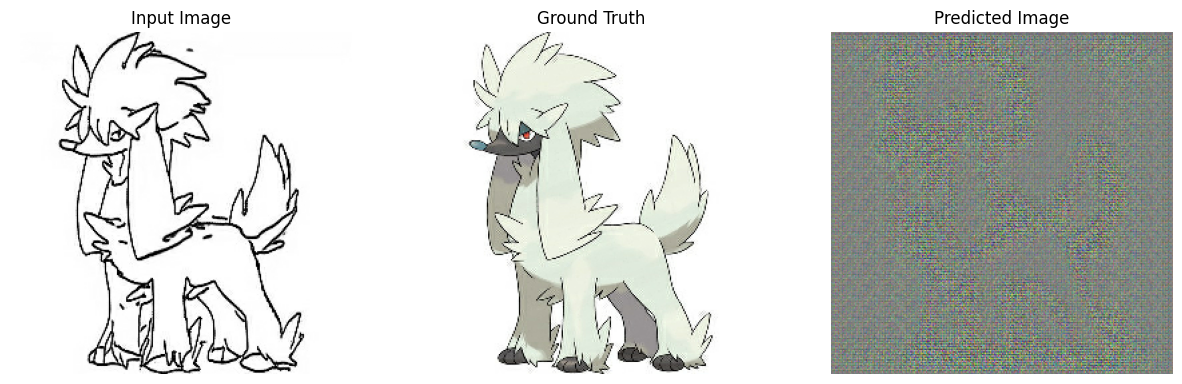

In [ ]:
def generate_images(model, test_input, tar):

    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']  

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])

        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

# Test the above function
for example_input, example_target in test_dataset.take(1):
    generate_images(gen_model, example_input, example_target)

# **LOAD TENSORBOARD**

In [ ]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# # # Clear any logs from previous runs
# !rm -rf ./logs/ 

# **TRAINING**

In [ ]:
#log_dir="logs/"

STEPS_PER_EPOCH = 200

# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# train_summary_writer = tf.summary.create_file_writer(train_log_dir)

# # Define metrics for avgeraging losses after each epoch
# train_combined_loss_metric = Mean(name='combined_loss')
# train_gen_total_loss_metric = Mean(name='train_gen_total_loss')
# train_disc_total_loss_metric = Mean(name='train_disc_total_loss')
# train_disc_total_loss_metric = Mean(name='train_disc_total_loss')

# Define metrics for avgeraging local losses after each step
# generator_total_loss_metric = tf.keras.metrics.Mean(name='generator_total_loss')
# generator_gan_loss_metric = tf.keras.metrics.Mean(name='generator_gan_loss')
# generator_l1_loss_metric = tf.keras.metrics.Mean(name='generator_l1_loss')
# generator_content_loss_metric = tf.keras.metrics.Mean(name='generator_content_loss')
# generator_style_loss_metric = tf.keras.metrics.Mean(name='generator_style_loss')

# discriminator_total_loss_metric = tf.keras.metrics.Mean(name='discriminator_total_loss')
# discriminator_real_loss_metric = tf.keras.metrics.Mean(name='discriminator_real_loss')
# discriminator_generated_loss_metric = tf.keras.metrics.Mean(name='discriminator_generated_loss')
# discriminator_style_loss_metric = tf.keras.metrics.Mean(name='discriminator_style_loss')
# discriminator_content_loss_metric = tf.keras.metrics.Mean(name='discriminator_content_loss')


def train_step(in_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_model_output = gen_model(in_image, training=True)

        disc_real_output = disc_model([in_image, target], training=True)

        # P(I) returned prediction, value close to 1 = real, value close to 0 = fake
        disc_generated_output = disc_model([in_image, gen_model_output], training=True)

        #print("disc_generated_output shape: ", disc_generated_output.shape)     #(1, 36, 36, 1)

        # save current original image before it is updated by the IDN
        # this is needed for passing to the loss functions
        original_sketch = in_image

        # C(I)      S(I)
        in_image, style_image = idn(disc_generated_output, 1, 512, content_channel=1)

        # Original gen loss call
        #gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_model_output, target)

        #print("Just before G")
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_content_loss, gen_style_loss = updated_generator_loss(disc_generated_output,
                                                                                                     gen_model_output,
                                                                                                     target,
                                                                                                     in_image,
                                                                                                     original_sketch,
                                                                                                     style_image,
                                                                                                     style_feature_map)        
        # Original disc loss call
        #disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # might need to preprocess "target" image before passing to vgg
        ground_truth_feature_map = vgg_model(target)

        #print("Just before D")
        disc_total_loss, disc_real_loss, disc_generated_loss, disc_style_loss, disc_content_loss = updated_discriminator_loss(disc_real_output,
                                                                                                                      disc_generated_output,
                                                                                                                      ground_truth_feature_map,
                                                                                                                      original_sketch,
                                                                                                                      style_feature_map,
                                                                                                                      style_image)

    #print("returned from D loss")

    # Update local metrics
    # generator_total_loss_metric.update_state(gen_total_loss)
    # generator_gan_loss_metric.update_state(gen_gan_loss)
    # generator_l1_loss_metric.update_state(gen_l1_loss)
    # generator_content_loss_metric.update_state(gen_content_loss)
    # generator_style_loss_metric.update_state(gen_style_loss)
    
    # discriminator_total_loss_metric.update_state(disc_total_loss)
    # discriminator_real_loss_metric.update_state(disc_real_loss)
    # discriminator_generated_loss_metric.update_state(disc_generated_loss)
    # discriminator_style_loss_metric.update_state(disc_style_loss)
    # discriminator_content_loss_metric.update_state(disc_content_loss)

    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, gen_model.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_total_loss, disc_model.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, gen_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc_model.trainable_variables))

    # Update total metrics
    # train_combined_loss_metric.update_state(gen_total_loss + disc_total_loss)
    # train_gen_total_loss_metric.update_state(gen_total_loss)
    # train_disc_total_loss_metric.update_state(disc_total_loss)

    # Write to Tensorboard
    #with train_summary_writer.as_default():
        # tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//100)
        # tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//100)
        # tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//100)
        # tf.summary.scalar('gen_content_loss', gen_content_loss, step=step//100)
        # tf.summary.scalar('gen_style_loss', gen_style_loss, step=step//100)

        # tf.summary.scalar('disc_total_loss', disc_total_loss, step=step//100)
        # tf.summary.scalar('disc_real_loss', disc_real_loss, step=step//100)
        # tf.summary.scalar('disc_generated_loss', disc_generated_loss, step=step//100)
        # tf.summary.scalar('disc_style_loss', disc_style_loss, step=step//100)
        # tf.summary.scalar('disc_content_loss', disc_content_loss, step=step//100)
        
        # Note the removal of the floor division by 100 as it's not necessary as I want to log this summary scalar less frequently.
        #tf.summary.scalar('disc_generated_output prediction', disc_generated_output, step=step)
    
    # Reset local loss metric states at the start of each epoch
    # if (step + 1) % STEPS_PER_EPOCH == 0:
    #     generator_total_loss_metric.reset_states()
    #     generator_gan_loss_metric.reset_states()
    #     generator_l1_loss_metric.reset_states()
    #     generator_content_loss_metric.reset_states()
    #     generator_style_loss_metric.reset_states()
        
    #     discriminator_total_loss_metric.reset_states()
    #     discriminator_real_loss_metric.reset_states()
    #     discriminator_generated_loss_metric.reset_states()
    #     discriminator_style_loss_metric.reset_states()
    #     discriminator_content_loss_metric.reset_states()

#from IPython.display import clear_output, display

# define a fixed location for the epoch output
#epoch_output = display("", display_id=True)

# ACTUAL TRAINING
def fit(train_ds, test_ds, steps):
    test_ds_input, test_ds_target = next(iter(test_ds.take(1)))
    start = time.time()

    EPOCHS = 5

    for epoch in range(EPOCHS):
        # Shuffle the dataset at the beginning of each epoch
        #train_ds_shuffled = train_ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)

        for step, (in_image, target) in train_ds.repeat().take(steps).enumerate():
            # Display an image every 10 steps
            if (step) % 10 == 0:
                display.clear_output(wait=True)

                if step != 0:
                    print(f'Time taken for 10 steps: {time.time()-start:.2f} sec\n')

                start = time.time()

                generate_images(gen_model, test_ds_input, test_ds_target)
                print(f"Step: {step}")

            # Training step
            train_step(in_image, target, step)
            #print('.', end='', flush=True)

            if (step + 1) % 10 == 0:
                print('.', end='', flush=True)

            # Save (checkpoint) the model every 10 steps
            if (step + 1) % 10 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)
        
        # Get average metrics for the epoch
        # epoch_train_loss = train_combined_loss_metric.result()
        # epoch_train_gen_total_loss = train_gen_total_loss_metric.result()
        # epoch_train_disc_total_loss = train_disc_total_loss_metric.result()

        # print(type(epoch_train_loss))
        # print(type(epoch_train_gen_total_loss))
        # print(type(epoch_train_disc_total_loss))

        # Write to Tensorboard
        # with train_summary_writer.as_default():
        #     tf.summary.scalar('epoch_train_loss', epoch_train_loss, step=epoch)
        #     tf.summary.scalar('epoch_train_gen_total_loss', epoch_train_gen_total_loss, step=epoch)
        #     tf.summary.scalar('epoch_train_disc_total_loss', epoch_train_disc_total_loss, step=epoch)

        # template = 'Epoch {}, Gen Loss: {}, Disc Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        # print (template.format(epoch+1,
        #                     epoch_train_loss.result(),
        #                     epoch_train_gen_total_loss.result(), 
        #                     epoch_train_disc_total_loss.result()))
        
        # template = 'Epoch {}, Training Loss: {}, Gen Loss: {}, Disc Loss: {}'
        # print(template.format(epoch+1, epoch_train_loss, epoch_train_gen_total_loss, epoch_train_disc_total_loss))

        # update the output
        # epoch_output.update("Epoch {} Training Loss: {} Gen Loss: {} Disc Loss: {}".format
        #                     (epoch+1, epoch_train_loss, epoch_train_gen_total_loss, epoch_train_disc_total_loss))

        
        # Reset avgerage losses metrics at the start of each epoch
        # train_combined_loss_metric.reset_states()
        # train_gen_total_loss_metric.reset_states()
        # train_disc_total_loss_metric.reset_states()

# **RUN TRAINING LOOP**

Time taken for 10 steps: 17.34 sec



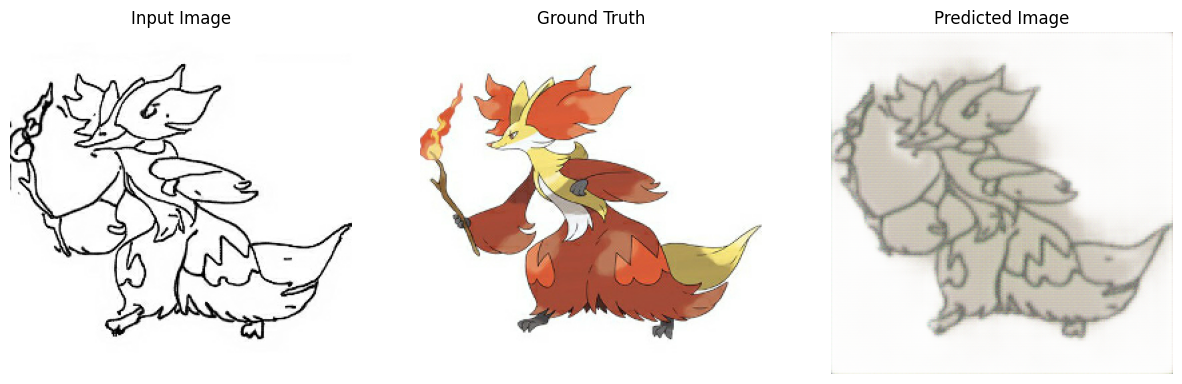

Step: 10
.

KeyboardInterrupt: ignored

In [ ]:
#tf.keras.backend.clear_session()

fit(train_dataset, test_dataset, steps=20)

#%tensorboard --logdir logs/gradient_tape

# **UPLOAD TENSORBOARD**

In [ ]:
# Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments.
# Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

# For publicly uploadingl logs to Tensorboard.dev
#tensorboard dev upload --logdir {log_dir}

# You can view the results of a previous run of this notebook on TensorBoard.dev.
# TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.
# It can also included inline using an <iframe>:

# display.IFrame(
#     src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#     width="100%",
#     height="1000px")

# **RESTORE LATEST CHECKPOINT AND TEST NETWORK**

In [ ]:
!ls {checkpoint_dir}

# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint		    ckpt-1.index		ckpt-2.index
ckpt-1.data-00000-of-00001  ckpt-2.data-00000-of-00001


# **GENERATE IMAGES USING TEST SET**

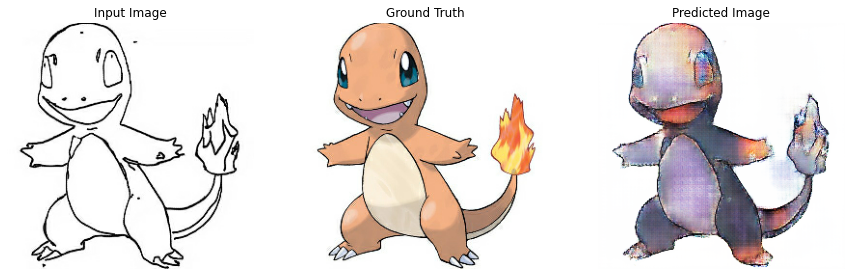

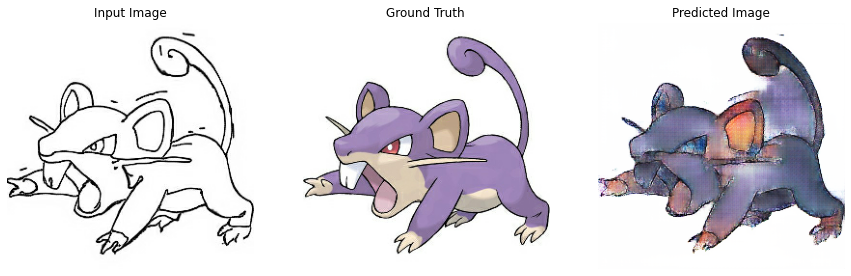

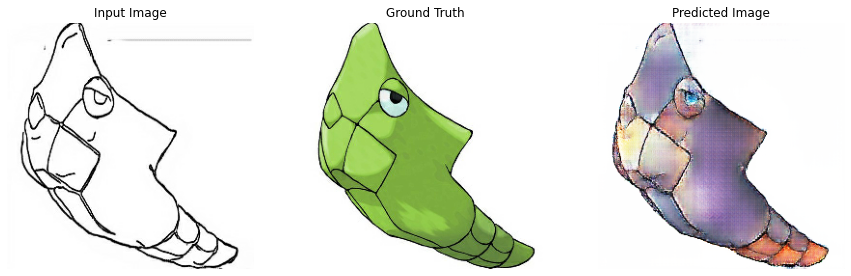

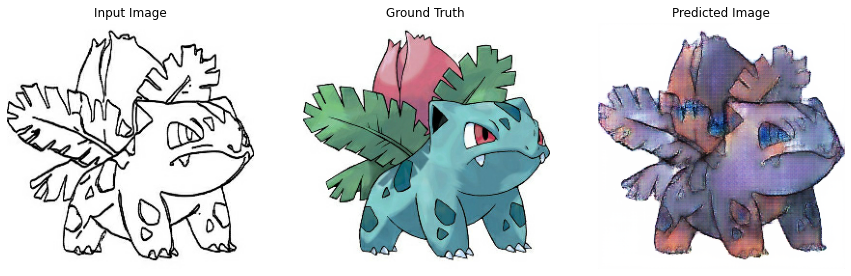

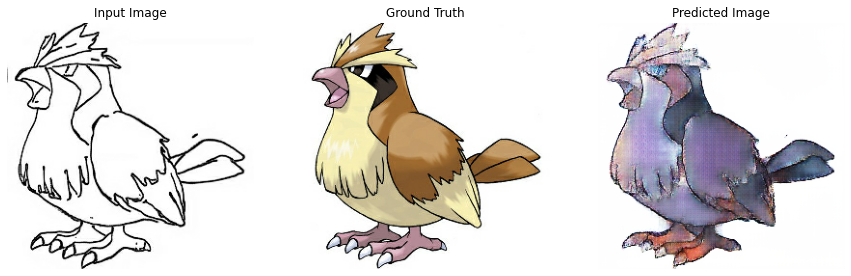

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(gen_model, inp, tar)

# **CALCULATE FID**